In [1]:
import torch

import numpy as np

import Models
import Data
import Train

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
train_data, test_data = Data.get_data(device)

In [3]:
designer = Models.Designer().to(device)
lookout = Models.Lookout().to(device)


designer_optimizer = torch.optim.AdamW(designer.parameters(), lr=1e-3)
lookout_optimizer = torch.optim.AdamW(lookout.parameters(), lr=1e-3)

designer_loss_weights = [1e0, 1e-5, 1e0] #Reconstruction, KLD, Lookout
mislabel_rate = 0.3 # train lookout on partially incorrect data to prevent it from learning camo too well, which would make designer "progress" useless

In [4]:
num_epochs = 40

designer_losses = []
lookout_losses = []
for epoch in range(num_epochs):
    designer_batch_losses, lookout_batch_losses = Train.train_epoch(device, designer, lookout, designer_optimizer, lookout_optimizer, designer_loss_weights, mislabel_rate, train_data)
    designer_losses.append(designer_batch_losses)
    lookout_losses.append(lookout_batch_losses)

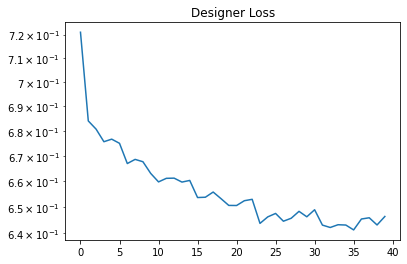

In [5]:
plt.semilogy(np.mean(designer_losses, axis=1))
plt.title("Designer Loss")
plt.show()

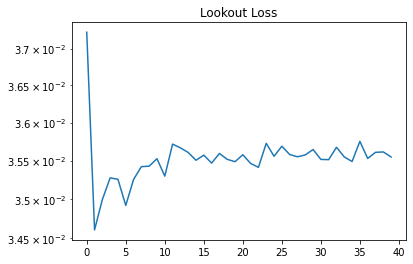

In [6]:
plt.semilogy(np.mean(lookout_losses, axis=1))
plt.title("Lookout Loss")
plt.show()

In [7]:
designer.eval()
lookout.eval()

r = torch.randperm(test_data.size(0))
n = 32
sections, strips = Data.get_batch(device, test_data, 0, n, r)
camo_images = Data.create_camo_images(device, designer, test_data, n, r)

camos, mu, log_var = designer(strips)

camo_strips, locs = Data.apply_camo(device, camos, strips)
preds = lookout(camo_strips)

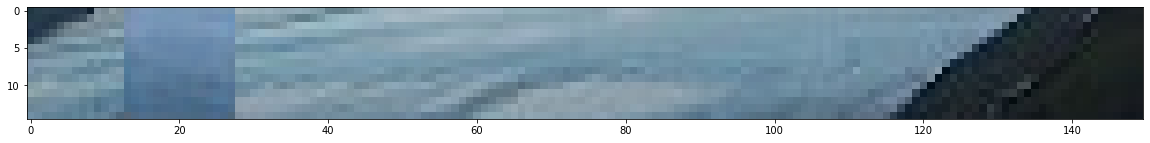

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(camo_strips[0].permute(1,2,0).cpu().detach().numpy())
plt.show()

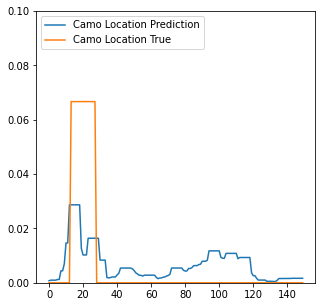

In [9]:
plt.figure(figsize=(5,5))
num = 0
plt.plot(preds[num].cpu().detach().numpy(), label="Camo Location Prediction")
plt.plot(locs[num].cpu().detach().numpy(), label="Camo Location True")
plt.legend(loc="upper left")
plt.ylim(0, 0.1)
plt.show()

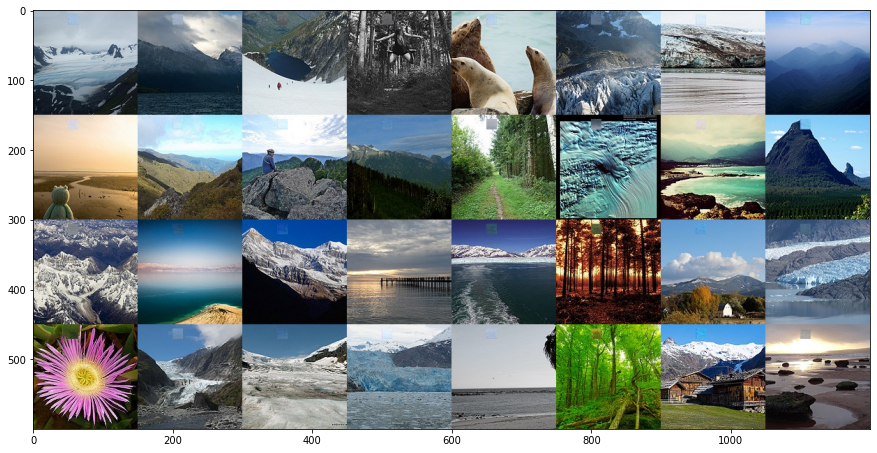

In [10]:
imgs_per_col = 8
c = 3
h = 150
w = 150
merged = torch.zeros(size=((c),h*(int(n/imgs_per_col-1e-10)+1),w*imgs_per_col))

for i in range(n):

    curr_col = i % imgs_per_col
    curr_row = int(i / imgs_per_col)

    merged[:,h*curr_row:h*(curr_row+1), w*curr_col:w*(curr_col+1)] = camo_images[i]

show = merged.permute(1,2,0).detach().numpy()

plt.figure(figsize=(15,15))
plt.imshow(show)
plt.show()

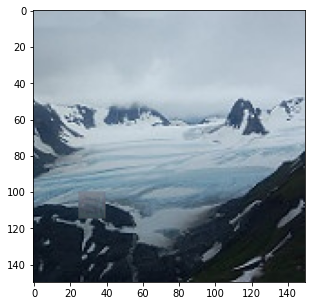

In [11]:
camo_image = Data.create_image_camo(device, designer, test_data[r][0], 100, 25)

plt.figure(figsize=(5,5))
plt.imshow(camo_image.permute(1,2,0).cpu().detach().numpy())
plt.show()

There are 16 features used


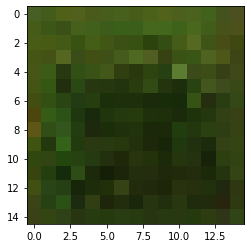

In [108]:
features = torch.randn(size=(1,designer.features_size), device=device)
print(f"There are {designer.features_size} features used")
generated_camo = designer.decode(features)

plt.imshow(generated_camo[0].permute(1,2,0).cpu().detach().numpy())
plt.show()